# Expériences à mener

- Comparer avec d'autres modèles pour lesquels le bruit du modèle dépend des observations précdentes
- Faire les probabilités de dépassement à un certain seuil
- Faire varier les conditions initiales de la covariance, voire ajouter un réseau qui donne la condition initiale
- Quel est l'intérêt d'avoir une composante HR et LR dans un cas comme celui-ci?



# Constatation

Lorsque l'on introduit une erreur au moindre carré supplémentaire, on obtient de bonnes reconstructions pour la moyenne.

# Récupération des données

In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.stats import t
print(torch.cuda.device_count())
print(os.getcwd())
import statsmodels

1
/home/VM-Nicolas-Lafon/These/Project_distribution_EVT


In [3]:
ncfile = Dataset('Results/modelsum-Exp2-epoch=598-val_loss=-1-Copy1.59.nc')
print(ncfile)
mu = ncfile['mean_pred']
cov = ncfile['cov_pred']
init = ncfile['inits']
target = ncfile['targets']


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Nb_samples(200), time(10), x(30)
    variables(dimensions): float32 mean_pred(Nb_samples, time, x), float32 cov_pred(Nb_samples, time, x), float32 inits(Nb_samples, time, x), float32 targets(Nb_samples, time, x), float64 Nb_samples(Nb_samples), float64 time(time), float64 space(x)
    groups: 


# Première visualisation

1.3841399
-4.3013844
4.6057525
Moyenne de la précision pour chaque pas de temps
[382.50412  430.58456  424.9188   416.08817  455.84888  452.72156
 413.06128   21.255117  14.857414  11.945085]
Moyenne de la covariance pour chaque pas de temps
[0.00261435 0.00232242 0.00235339 0.00240334 0.00219371 0.00220886
 0.00242095 0.04704749 0.06730647 0.08371644]


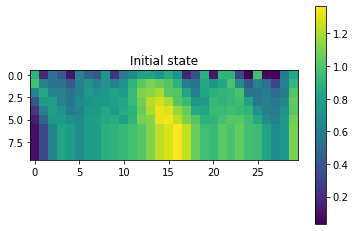

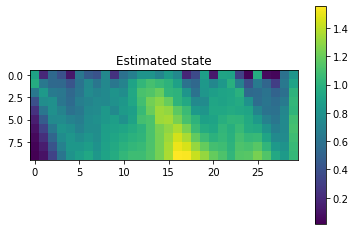

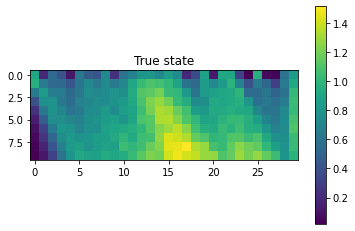

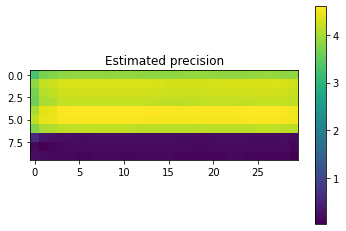

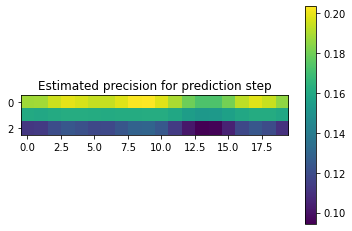

In [6]:
plt.figure()
plt.title('Initial state')
plt.imshow(init[10,:,:])
plt.colorbar()
plt.figure()
plt.title('Estimated state')
plt.imshow(mu[10,:,:])
plt.colorbar()
plt.figure()
plt.title('True state')
plt.imshow(target[10,:,:])
plt.colorbar()
plt.figure()
plt.title('Estimated precision')
plt.imshow(np.abs(cov[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('Estimated precision for prediction step')
plt.imshow(np.abs(cov[10,7:10,5:25]))
plt.colorbar()
print(np.mean(cov))
print(np.min(cov))
print(np.max(cov))
print("Moyenne de la précision pour chaque pas de temps")
print(np.mean(np.mean(np.abs(cov),0),1)*100)
print("Moyenne de la covariance pour chaque pas de temps")
print(1/(np.mean(np.mean(np.abs(cov),0),1)*100))

Variance pour chaque pas de temps
[9.9939052e-07 9.8061150e-07 1.0001653e-06 1.0075714e-06 1.0249212e-06
 9.8486100e-07 1.0112057e-06 1.7423884e-03 3.2434873e-03 4.5847083e-03]
Variance pour la prévision avec la persistance
[0.00566384 0.0185768  0.0381052 ]


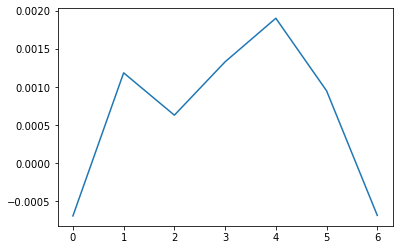

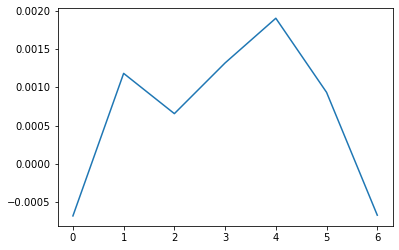

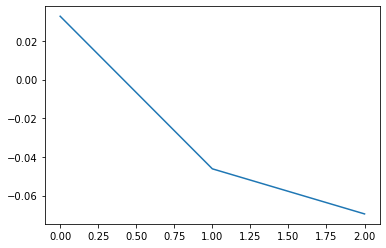

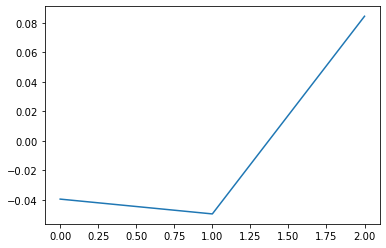

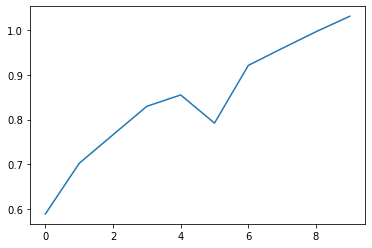

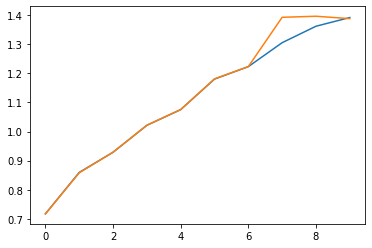

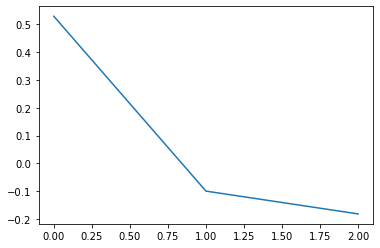

In [24]:

plt.plot(init[10,0:7,10]-target[10,0:7,10])
plt.figure()
plt.plot(mu[10,0:7,10]-target[10,0:7,10])
plt.figure()
plt.plot(init[10,7:10,11]-target[10,7:10,11])
plt.figure()
plt.plot(mu[10,7:10,10]-target[10,7:10,10])
plt.figure()
plt.plot(mu[10,:,10])
plt.figure()
plt.plot(mu[50,:,10])
plt.plot(target[50,:,10])
plt.figure()
plt.plot(cov[0,7:10,0])

print("Variance pour chaque pas de temps")
print(np.mean(np.mean((mu[:,:,:]-target[:,:,:])**2,0),1))

print("Variance pour la prévision avec la persistance")
print(np.mean(np.mean((init[:,7:10,:]-target[:,7:10,:])**2,0),1))

# Comparaison entre la covariance réel et estimé

(200, 10, 30)


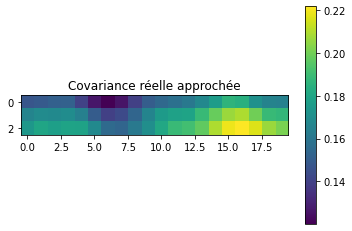

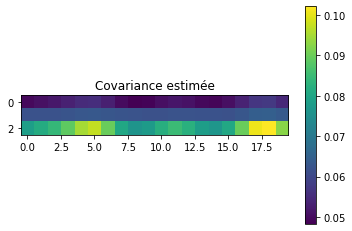

In [9]:
#Cas du modèle multiplicatif

DX = 30
indice = 20
Model_noise =0.02
Obs_noise = 0.001
print(target.shape)
real_cov = torch.zeros(10,30)
real_cov[0:7,:]=Obs_noise
for i in range(7,10):
    for j in range(30):
        real_cov[i,j] = (0.6*real_cov[i-1,j])**2+(0.4*real_cov[i-1,(j-1)%DX])**2+(0.2*real_cov[i-1 , (j+1)%DX])**2+(0.1*real_cov[i-1,(j+2)%DX])**2+(0.05*real_cov[i-1, (j-2)%DX])**2
        real_cov[i,j] += (target[indice,i-1,j]**2+target[indice,i-1,(j-1)%DX]**2)*(0.02**2)
        real_cov[i,j] =np.sqrt(real_cov[i,j])
real_cov[7:10,:] = torch.sqrt(real_cov[7:10,:])


estimated_cov = 1/np.abs(cov[indice,:,:])/100


plt.figure()
plt.title("Covariance réelle approchée")
plt.imshow(real_cov[7:10,5:25])
plt.colorbar()
plt.figure()
plt.title("Covariance estimée")
plt.imshow(estimated_cov[7:10,5:25])
plt.colorbar()

# Opérateur dynamique

In [10]:
from models import Gradient_img, LitModel
import torch

In [11]:
ckpt_path ='Results/modelsum-Exp2-epoch=598-val_loss=-1-Copy1.59.ckpt'
lit_cls = LitModel
mod = lit_cls.load_from_checkpoint(ckpt_path, 
                                                    mean_Tr=0, 
                                                    std_Tr = 0
                                                    )

Phi_r(
  (encoder): Encoder(
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (convTr): ConvTranspose2d(10, 10, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (NNLR): Sequential(
      (0): BiLinUnit(
        (conv1): Conv2d(10, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv2): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(100, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin1): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (NNHR): Sequential(
      (0): BiLinUnit(
        (conv1): Conv2d(10, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)


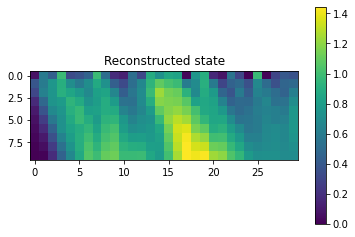

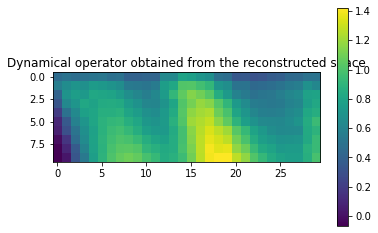

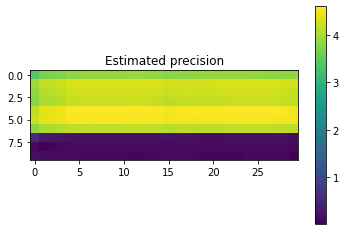

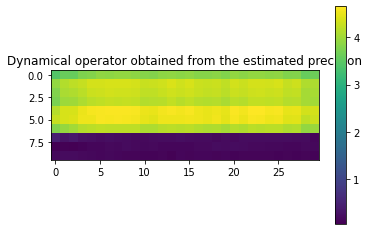

In [14]:
print(mod.model.phi_r)
ex= torch.zeros(1,10,30,2)
print(ex.shape)
ex[0,:,:,0] = torch.Tensor(mu[100,:,:])
ex[0,:,:,1] = torch.Tensor(cov[100,:,:])
i0 = mod.model.phi_r(ex).detach().numpy()
plt.figure()
plt.title("Reconstructed state")
plt.imshow(ex[0,:,:,0])
plt.colorbar()
plt.figure()
plt.title("Dynamical operator obtained from the reconstructed space")
plt.imshow(i0[0,:,:,0])
plt.colorbar()
plt.figure()
plt.title("Estimated precision")
plt.imshow(np.abs(ex[0,:,:,1]))
plt.colorbar()
plt.figure()
plt.title("Dynamical operator obtained from the estimated precision")
plt.imshow(np.abs(i0[0,:,:,1]))
plt.colorbar()

print("Différence moyenne entre phi et la sortie")
tot = torch.zeros(200,10,30,2)

 # Scoring rules

On s'intéresse aux p-scores : 

In [17]:
def logarithmic_scores(t,mu,sig):
    return(0.5*(((t-mu)*sig*100)**2)-np.log(sig*100)+0.5*np.log(2*np.pi))


scores = logarithmic_scores(target[:,:,:],mu[:,:,:],np.abs(cov[:,:,:]))
0.5*np.log(2*np.pi)
np.log(1000)

6.907755278982137

In [18]:
scores.shape
np.mean(np.mean(scores[:,:,:],0),1)

masked_array(data=[-4.954248423258464, -5.05505409749349,
                   -5.042359680175782, -5.024480082194009,
                   -5.096490692138672, -5.095413167317708,
                   -5.0181452026367195, -1.7766146850585933,
                   -1.3164009730021162, -1.2499286829630532],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20)

In [26]:
def almost_entropy_score(t,mu,sig):
    res = -np.sqrt(sig*100)/(np.sqrt(2*np.pi))*np.exp(-0.5*(t-mu)**2*((sig*100)**2))
    res= res * logarithmic_scores(t,mu,sig)
    return res

scores = almost_entropy_score(target[:,:,:],mu[:,:,:],np.abs(cov[:,:,:]))

In [27]:
scores.shape
np.mean(np.mean(scores[:,:,:],0),1)

masked_array(data=[36.16612906901041, 38.5999393717448, 38.26714925130208,
                   37.830392740885415, 39.549262532552085,
                   39.6062802734375, 37.652883300781255,
                   2.8606814880371094, 1.8180441430409748,
                   1.5494678738911947],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value=1e+20)

Probabilité de dépassement à un certain seuil


In [169]:
print(np.sum(target[:,7,10]>1.2))
p_dep = 53/200/30
print(p_dep)


26
0.008833333333333334


In [167]:
from scipy.stats import norm
Res= torch.zeros(200)
for i in range(200):
        Res[i] = norm.cdf((0.25-mu[i,7,10])*(100*cov[i,7,10]))

In [170]:
Ind = np.where(target[:,7,10]>1.2)
print(1-Res[Ind])
Ind_ = np.where(target[:,7,10]<1.2) 
print(1-Res[Ind_])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,